In [17]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt
import heapq
import itertools

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataSet

## Environment

In [26]:
# used to create new environement
class Create2dGrid:
    def __init__(self):
        pass

    def PointInsideQuadBatch(self, points, quad):
        def Cross(a, b):
            return a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0]

        crosses = []

        for i in range(4):
            p1 = quad[i]
            p2 = quad[(i + 1) % 4]
            edge = p2 - p1
            toPoint = points - p1
            c = Cross(edge.unsqueeze(0), toPoint)
            crosses.append(c)

        crosses = torch.stack(crosses, dim=1)

        inside_pos = (crosses >= 0).all(dim=1)
        inside_neg = (crosses <= 0).all(dim=1)

        return inside_pos | inside_neg

    def Get(self, obstaclesProb = 0.5):
        grid = torch.zeros((500, 500))
        for i in range(10):
            for j in range(10):
                if torch.rand(1) > obstaclesProb:
                    continue

                centerPos = torch.tensor([i * 50 + 25, j * 50 + 25], dtype=torch.float32)

                topRight    = torch.tensor([ torch.rand(1).item()*30,  torch.rand(1).item()*30])
                bottomRight = torch.tensor([ torch.rand(1).item()*30, -torch.rand(1).item()*30])
                topLeft     = torch.tensor([-torch.rand(1).item()*30,  torch.rand(1).item()*30])
                bottomLeft  = torch.tensor([-torch.rand(1).item()*30, -torch.rand(1).item()*30])

                quad = torch.stack([topLeft, topRight, bottomRight, bottomLeft]) + centerPos



                minX = int(torch.clamp(quad[:, 0].min(), 0, 499))
                maxX = int(torch.clamp(quad[:, 0].max(), 0, 499))
                minY = int(torch.clamp(quad[:, 1].min(), 0, 499))
                maxY = int(torch.clamp(quad[:, 1].max(), 0, 499))

                xs = torch.arange(minX, maxX + 1)
                ys = torch.arange(minY, maxY + 1)
                X, Y = torch.meshgrid(xs, ys, indexing="ij")

                points = torch.stack([X.flatten(), Y.flatten()], dim=1)
                mask = self.PointInsideQuadBatch(points, quad)
                grid[X.flatten()[mask], Y.flatten()[mask]] = 1
        return grid

    def ShowGrid(self, index):
        plt.imshow(self.grid[index], cmap="gray")
        plt.axis("off")
        plt.show()


## Trajectory

In [42]:
counter = itertools.count()

def heuristic(a, b):
    return np.linalg.norm(a - b)

def Check(grid, i, j):
    i, j = int(i), int(j)
    H, W = grid.shape
    return 0 <= i < H and 0 <= j < W and not grid[i][j]

def AStar(grid, start, goal, speed = 2):
    start = tuple(start)
    goal  = tuple(goal)

    open_set = []
    heapq.heappush(open_set, (0, next(counter), start))

    g_cost = {start: 0.0}
    parent = {start: None}
    visited = set()

    step = speed
    dirs = [
        (step, 0), (-step, 0), (0, step), (0, -step),
        (step, step), (step, -step), (-step, step), (-step, -step)
    ]

    while open_set:
        _, _, current = heapq.heappop(open_set)

        if current in visited:
            continue

        visited.add(current)
        if ((current[0] - goal[0]) ** 2 + (current[1] - goal[1]) ** 2) ** 0.5 < step:
            parent[goal] = current
            break

        for dx, dy in dirs:
            nx, ny = current[0] + dx, current[1] + dy

            if not Check(grid, nx, ny):
                continue

            neighbor = (nx, ny)

            step_cost = np.sqrt(dx*dx + dy*dy)
            new_g = g_cost[current] + step_cost

            if neighbor not in g_cost or new_g < g_cost[neighbor]:
                g_cost[neighbor] = new_g
                parent[neighbor] = current
                f = new_g + heuristic(
                    np.array(neighbor),
                    np.array(goal)
                )
                heapq.heappush(
                    open_set,
                    (f, next(counter), neighbor)
                )
    if goal not in parent:
        return torch.empty((0, 2))

    path = []
    node = goal
    while node is not None:
        path.append(np.array(node))
        node = parent[node] 

    path.reverse()
    path = np.stack(path)
    return torch.from_numpy(path)

In [43]:
def ShowTrajInEnv(grid, traj, points=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.cpu().numpy().T, cmap="gray", origin="lower", extent=[0, 500, 0, 500])

    traj_np = traj.detach().cpu().numpy()
    x = traj_np[:, 0]
    y = traj_np[:, 1]

    plt.plot(x, y, color="cyan", linewidth=2, label="Trajectory", alpha=0.8)
    plt.scatter(x[0], y[0], color="green", s=100, label="Start", edgecolors='white', zorder=5)
    plt.scatter(x[-1], y[-1], color="red", s=100, label="Goal", edgecolors='white', zorder=5)
    if points:
        for pnt in points:
            plt.scatter(pnt[0], pnt[1], color="magenta", s=80, label="Point Obstacle")

    plt.title("Trajectory Overlaid on Environment")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## Optimization

In [44]:
def CreateSignedDistanceMap(bMask):
    dist_outside = distance_transform_edt(bMask == 0)
    dist_inside = distance_transform_edt(bMask == 1)
    sdf = dist_outside - dist_inside
    return torch.from_numpy(sdf).float()

class MapLossFunction(nn.Module):
    def __init__(self, dist_map, ref_traj, w_smooth=0.2, w_space=0.0, 
                 w_length=0, w_collision=0.0, w_ref=0.8, safety_radius=0.5):
        super().__init__()
        self.register_buffer('dist_map', dist_map)
        self.register_buffer('ref_traj', ref_traj) 
        
        self.w_smooth = w_smooth
        self.w_space = w_space
        self.w_length = w_length
        self.w_collision = w_collision
        self.w_ref = w_ref
        self.safety_radius = safety_radius

    def forward(self, traj):
        vel = traj[:, 1:] - traj[:, :-1]
        acc = vel[:, 1:] - vel[:, :-1]
        lossSmooth = (acc ** 2).sum()
        
        segmentLens = torch.norm(vel, dim=-1) + 1e-6
        meanLen = segmentLens.mean(dim=1, keepdim=True)
        lossSpace = ((segmentLens - meanLen) ** 2).sum()
        
        lossDistance = segmentLens.sum()
        
        grid_coords = (traj[..., :2] / 500) - 1.0 
        grid_coords = grid_coords.unsqueeze(1)
        input_map = self.dist_map.unsqueeze(0).unsqueeze(0)
        dist_values = F.grid_sample(input_map, grid_coords, mode='bilinear', align_corners=True)
        
        diff = self.safety_radius - dist_values
        lossCollision = torch.relu(diff).pow(2).sum()

        lossRef = torch.mean((traj - self.ref_traj) ** 2)

        tLoss = (self.w_smooth * lossSmooth) + \
                (self.w_space * lossSpace) + \
                (self.w_length * lossDistance) + \
                (self.w_collision * lossCollision) + \
                (self.w_ref * lossRef)
        
        return tLoss
    
def OptimizeTrajectory(tau, start, end, map_data, iter=20, lr=0.2):
    map_dist = CreateSignedDistanceMap(map_data).to(device)
    sgdLoss = MapLossFunction(map_dist, tau.clone(), safety_radius=40).to(device)
    tau = tau.detach().clone().to(device).requires_grad_(True)
    
    optimizer = torch.optim.Adam([tau], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iter, eta_min=1e-3)
    
    for _ in range(iter):
        optimizer.zero_grad()
        tau_batched = tau.unsqueeze(0) 
        
        tauLoss = sgdLoss(tau_batched)        
        tauLoss.backward()
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            tau[0] = start.to(device)
            tau[-1] = end.to(device)
            
    return tau.detach().cpu()

In [45]:
class Dataset:
    def __init__(self, sizeOfDataset = 5000):
        self.size = sizeOfDataset
        self.env = Create2dGrid()
    
    def UpdateMap(self, grid, start, end, radius=20):
        gridC = grid.clone()
        H, W = gridC.shape
        
        for pt in [start, end]:
            cx, cy = int(pt[0]), int(pt[1])
            
            x0, x1 = max(0, cx - radius), min(H, cx + radius + 1)
            y0, y1 = max(0, cy - radius), min(W, cy + radius + 1)
            
            gridC[x0:x1, y0:y1] = 0
            
        return gridC

    def Get(self, obstaclesProb = 0.5, speed = 2):
        grid = self.env.Get(obstaclesProb)
        start, goal = torch.rand(2) * 500, torch.rand(2) * 500
        grid = self.UpdateMap(grid, start, goal)

        aStartTraj = AStar(grid, start.numpy(), goal.numpy(), speed)
        optimTraj = OptimizeTrajectory(aStartTraj, start, goal, grid)
        return grid, aStartTraj, optimTraj

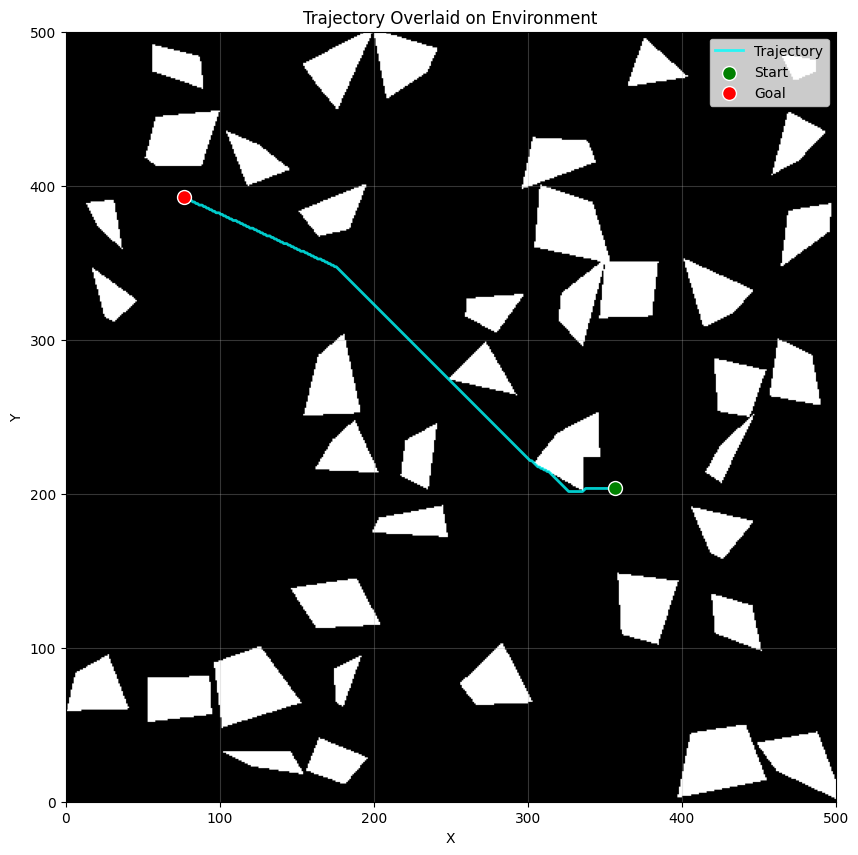

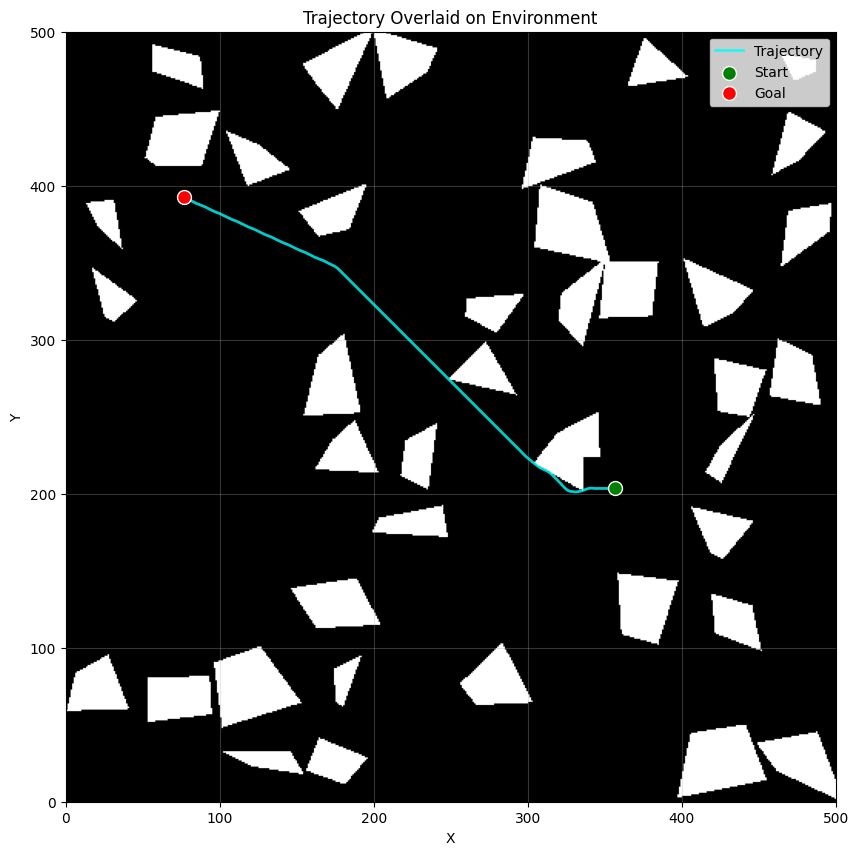

In [60]:
ds = Dataset()
grid, aTraj, oTraj = ds.Get(0.4, speed=1)
ShowTrajInEnv(grid, aTraj)
ShowTrajInEnv(grid, oTraj)

# Trajectory Generation